# 1. Project Overview

 Sistem rekomendasi ini dibuat untuk membantu pengguna menemukan film sesuai minat mereka menggunakan dataset MovieLens 100K. Dua pendekatan utama digunakan: Content-based Filtering (berbasis kemiripan genre film) dan Collaborative Filtering (berbasis pola rating pengguna). Proyek ini mencakup pemuatan data, eksplorasi, modeling, dan evaluasi.

# 2. Import Library
Pada tahap ini, kita mengimpor library yang dibutuhkan seperti pandas dan numpy untuk manipulasi data, matplotlib dan seaborn untuk visualisasi, serta sklearn untuk pemrosesan data dan evaluasi model. Selain itu, digunakan library lightfm untuk membangun model collaborative filtering.

In [2]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip install lightfm
from lightfm import LightFM
from lightfm.data import Dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831162 sha256=573121c935015f920b8888d8c0c311bc6c5d09e1a4c3e7f832399b5798fd7cca
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm


## 3. Data Understanding & Loading Dataset

Di tahap ini, file data MovieLens 100K (u.data untuk rating dan u.item untuk info film) di-upload dan dimuat ke dalam DataFrame.
* Data rating berisi userId, movieId, rating, dan timestamp.
* Data film memuat movieId, judul, tanggal rilis, dan genre dengan format one-hot encoding.
Setelah dimuat, data ditampilkan untuk verifikasi.

In [3]:
# Data Understanding & Loading Dataset
from google.colab import files
uploaded = files.upload()  # Pilih u.data dan u.item

# Load rating data
ratings = pd.read_csv('u.data', sep='\t', names=['userId', 'movieId', 'rating', 'timestamp'])
print('Contoh data rating:')
print(ratings.head())

# Load movie data
movie_columns = [
    'movieId', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', names=movie_columns)
print('\nContoh data film:')
print(movies[['movieId', 'title']].head())

Contoh data rating:
   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596

Contoh data film:
   movieId              title
0        1   Toy Story (1995)
1        2   GoldenEye (1995)
2        3  Four Rooms (1995)
3        4  Get Shorty (1995)
4        5     Copycat (1995)


In [4]:
# Cek kondisi data (missing value dan duplikat)
print("\nMissing values pada ratings:\n", ratings.isnull().sum())
print("Duplikat pada ratings:", ratings.duplicated().sum())
print("Missing values pada movies:\n", movies.isnull().sum())
print("Duplikat pada movies:", movies.duplicated().sum())


Missing values pada ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
Duplikat pada ratings: 0
Missing values pada movies:
 movieId                  0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children's               0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64
Duplikat pada movies: 0


### Membuat Kolom 'genres' Gabungan

Karena genre pada dataset menggunakan one-hot encoding (setiap genre berupa kolom terpisah dengan nilai 0/1), kita menggabungkannya ke satu kolom 'genres' agar lebih mudah digunakan pada modeling berbasis konten.


In [5]:
# Membuat kolom 'genres' gabungan
genre_cols = [
    'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

def combine_genres(row):
    return '|'.join([g for g in genre_cols if row[g] == 1])

movies['genres'] = movies[genre_cols].apply(combine_genres, axis=1)
print(movies[['title', 'genres']].head())


               title                       genres
0   Toy Story (1995)  Animation|Children's|Comedy
1   GoldenEye (1995)    Action|Adventure|Thriller
2  Four Rooms (1995)                     Thriller
3  Get Shorty (1995)          Action|Comedy|Drama
4     Copycat (1995)         Crime|Drama|Thriller


### Gabung Data Rating dan Movie
Data rating dan movie digabung berdasarkan movieId agar setiap baris rating memuat judul film dan genre-nya. Data ini menjadi dasar untuk eksplorasi dan pemodelan.

In [6]:
# Gabung data rating dan movie
df = ratings.merge(movies[['movieId', 'title', 'genres']], on='movieId')
print(df.head())

   userId  movieId  rating  timestamp                       title  \
0     196      242       3  881250949                Kolya (1996)   
1     186      302       3  891717742    L.A. Confidential (1997)   
2      22      377       1  878887116         Heavyweights (1994)   
3     244       51       2  880606923  Legends of the Fall (1994)   
4     166      346       1  886397596         Jackie Brown (1997)   

                             genres  
0                            Comedy  
1  Crime|Film-Noir|Mystery|Thriller  
2                 Children's|Comedy  
3         Drama|Romance|War|Western  
4                       Crime|Drama  


### Eksplorasi Data

Eksplorasi awal dilakukan untuk mengetahui jumlah user unik, jumlah film, jumlah rating, distribusi rating, serta genre film paling populer.

* Distribusi rating membantu memahami pola rating user.
* Analisis genre populer dapat memberikan insight tentang minat umum penonton.

In [7]:
# Eksplorasi Data
print(f"Jumlah user unik: {df['userId'].nunique()}")
print(f"Jumlah film unik: {df['movieId'].nunique()}")
print(f"Jumlah rating: {len(df)}")

Jumlah user unik: 943
Jumlah film unik: 1682
Jumlah rating: 100000


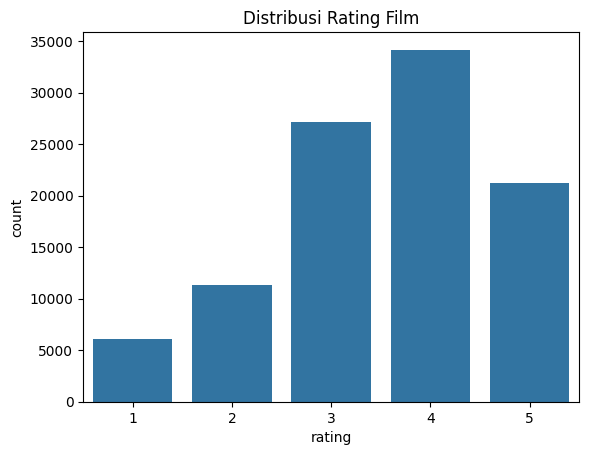

In [8]:
# Distribusi rating
sns.countplot(x='rating', data=df)
plt.title('Distribusi Rating Film')
plt.show()

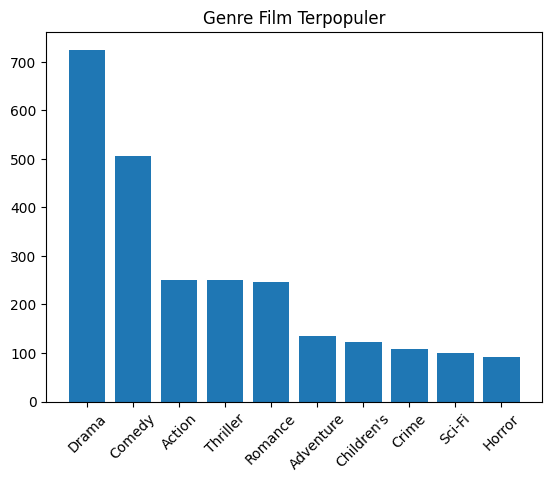

In [9]:
# Genre terpopuler
from collections import Counter
all_genres = '|'.join(movies['genres']).split('|')
genre_counts = Counter(all_genres)
plt.bar(*zip(*genre_counts.most_common(10)))
plt.title('Genre Film Terpopuler')
plt.xticks(rotation=45)
plt.show()

## 4. Modeling

Model Content-based Filtering dibangun menggunakan TF-IDF pada kolom genre, kemudian dihitung cosine similarity antar film. Fungsi rekomendasi akan mengambil film yang memiliki kemiripan genre tertinggi terhadap film yang dipilih user.


In [10]:
# Content-based Filtering
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def content_based_recommendations(title, top_n=5):
    idx = movies[movies['title'].str.lower() == title.lower()].index
    if len(idx) == 0:
        return 'Film tidak ditemukan.'
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices][['title', 'genres']]

# Contoh rekomendasi genre mirip dengan "Toy Story (1995)"
print("\nRekomendasi Content-Based untuk Toy Story (1995):")
print(content_based_recommendations("Toy Story (1995)"))


Rekomendasi Content-Based untuk Toy Story (1995):
                                      title                       genres
421  Aladdin and the King of Thieves (1996)  Animation|Children's|Comedy
101                  Aristocats, The (1970)         Animation|Children's
403                        Pinocchio (1940)         Animation|Children's
624          Sword in the Stone, The (1963)         Animation|Children's
945           Fox and the Hound, The (1981)         Animation|Children's


### Collaborative Filtering dengan LightFM
Model Collaborative Filtering dibuat menggunakan library LightFM, yang mengolah data interaksi user-film untuk mempelajari pola preferensi. Data interaksi dipersiapkan lalu model dilatih dengan algoritma WARP. Fungsi rekomendasi mengembalikan daftar film yang diprediksi paling disukai user.

In [11]:
# Collaborative Filtering dengan LightFM
dataset = Dataset()
dataset.fit((x for x in ratings['userId']), (x for x in ratings['movieId']))
(interactions, weights) = dataset.build_interactions(
    [(row['userId'], row['movieId'], row['rating']) for idx, row in ratings.iterrows()]
)

model = LightFM(loss='warp')
model.fit(interactions, epochs=10, num_threads=2)

#### Fungsi rekomendasi film untuk user dengan collaborative filtering LightFM
Fungsi ini memberikan daftar film rekomendasi untuk user tertentu berdasarkan hasil prediksi model collaborative filtering. Hasil rekomendasi dapat digunakan untuk melihat kualitas saran yang diberikan sistem.

In [12]:
def get_collab_recommendations(user_id, top_n=5):
    user_id = int(user_id)
    n_items = interactions.shape[1]
    scores = model.predict(user_id, np.arange(n_items))
    top_items = np.argsort(-scores)[:top_n]
    movie_ids = [list(dataset.mapping()[2].keys())[list(dataset.mapping()[2].values()).index(i)] for i in top_items]
    return movies[movies['movieId'].isin(movie_ids)][['title', 'genres']]

print("\nRekomendasi Collaborative Filtering untuk user ID 1:")
print(get_collab_recommendations(1))


Rekomendasi Collaborative Filtering untuk user ID 1:
                             title                     genres
116               Rock, The (1996)  Action|Adventure|Thriller
120  Independence Day (ID4) (1996)          Action|Sci-Fi|War
257                 Contact (1997)               Drama|Sci-Fi
287                  Scream (1996)            Horror|Thriller
293               Liar Liar (1997)                     Comedy


## 5. Evaluation

Pada tahap ini, hasil rekomendasi untuk beberapa user dan judul film divisualisasikan dan ditampilkan untuk dievaluasi secara kualitatif. Tujuannya untuk melihat apakah rekomendasi tampak masuk akal dan relevan.






# Hit@5
Hit@5: Mengecek apakah minimal 1 film relevan muncul pada top-5 rekomendasi.

In [17]:
def hit_at_k(recommended_ids, relevant_ids, k=5):
    hit = any(i in relevant_ids for i in recommended_ids[:k])
    return int(hit)

user_id = 1
user_rated = df[(df['userId'] == user_id) & (df['rating'] >= 4)]['movieId'].tolist()
recommended = get_collab_recommendations(user_id, top_n=5)
recommended_ids = movies[movies['title'].isin(recommended['title'])]['movieId'].tolist()

print(f'Collaborative Filtering - Hit@5 untuk user {user_id}: {hit_at_k(recommended_ids, user_rated, 5)}')


Collaborative Filtering - Hit@5 untuk user 1: 1


# Recall@5
Recall@5: Mengukur proporsi film relevan yang berhasil direkomendasikan pada top-5 rekomendasi.

In [18]:
def recall_at_k(recommended_ids, relevant_ids, k=5):
    if len(relevant_ids) == 0:
        return 0.0
    hit_count = len(set(recommended_ids[:k]) & set(relevant_ids))
    return hit_count / len(relevant_ids)

print(f'Collaborative Filtering - Recall@5: {recall_at_k(recommended_ids, user_rated, 5):.2f}')


Collaborative Filtering - Recall@5: 0.01


# Precision@5
Precision@5: Mengukur proporsi item pada top-5 rekomendasi yang benar-benar relevan.

In [19]:
precision_at_5 = len(set(user_rated) & set(recommended_ids)) / 5
print(f'Collaborative Filtering - Precision@5 untuk user {user_id}: {precision_at_5:.2f}')

Collaborative Filtering - Precision@5 untuk user 1: 0.40


# MAP@5
MAP@5 (Mean Average Precision@5): Menghitung rata-rata precision pada setiap posisi hingga 5 di daftar rekomendasi.

In [20]:
def apk(actual, predicted, k=5):
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    return score / min(len(actual), k) if actual else 0.0

print(f'Collaborative Filtering - MAP@5: {apk(user_rated, recommended_ids, 5):.2f}')

Collaborative Filtering - MAP@5: 0.23


# RMSE
RMSE (Root Mean Squared Error): Mengukur rata-rata kesalahan prediksi rating oleh model terhadap data aktual.

In [21]:
from sklearn.metrics import mean_squared_error
user_interactions = interactions.tocsr()[user_id]
known_items = user_interactions.indices
pred_ratings = model.predict(user_id, known_items)
actual_ratings = user_interactions.data
if len(actual_ratings) > 0:
    rmse = np.sqrt(mean_squared_error(actual_ratings, pred_ratings))
    print(f'Collaborative Filtering - RMSE untuk user {user_id}: {rmse:.2f}')
else:
    print('User belum punya data rating untuk evaluasi RMSE.')

Collaborative Filtering - RMSE untuk user 1: 2.83


# Coverage
Coverage: Mengukur persentase item unik di dataset yang berhasil direkomendasikan kepada seluruh user.

In [22]:
all_recommended = set()
for uid in range(1, 11):
    recommended = get_collab_recommendations(uid, top_n=5)
    rec_ids = movies[movies['title'].isin(recommended['title'])]['movieId'].tolist()
    all_recommended.update(rec_ids)
coverage = len(all_recommended) / movies['movieId'].nunique()
print(f'Collaborative Filtering - Coverage 10 user: {coverage:.2%}')

Collaborative Filtering - Coverage 10 user: 1.25%


# Precision@5 Content-Based Filtering
Precision@5: Mengukur proporsi film dengan genre identik di antara 5 rekomendasi teratas pada Content-Based Filtering.

In [23]:
def content_based_precision_at_k(input_title, k=5):
    input_genre = movies.loc[movies['title'] == input_title, 'genres'].values[0]
    ground_truth = movies[(movies['genres'] == input_genre) & (movies['title'] != input_title)].title.tolist()
    rekomendasi = content_based_recommendations(input_title, top_n=k)
    if isinstance(rekomendasi, str): return 0
    recommended_titles = rekomendasi['title'].tolist()
    benar = len(set(recommended_titles) & set(ground_truth))
    return benar / k if k > 0 else 0

title_test = "Toy Story (1995)"
print(f'Content-Based Filtering - Precision@5 untuk {title_test}: {content_based_precision_at_k(title_test, 5):.2f}')

Content-Based Filtering - Precision@5 untuk Toy Story (1995): 0.20


# Recall@5 Content-Based Filtering
Recall@5: Mengukur proporsi film dengan genre identik dari seluruh ground truth yang berhasil direkomendasikan pada Content-Based Filtering.

In [24]:
def content_based_recall_at_k(input_title, k=5):
    input_genre = movies.loc[movies['title'] == input_title, 'genres'].values[0]
    ground_truth = movies[(movies['genres'] == input_genre) & (movies['title'] != input_title)].title.tolist()
    if len(ground_truth) == 0: return 0
    rekomendasi = content_based_recommendations(input_title, top_n=k)
    if isinstance(rekomendasi, str): return 0
    recommended_titles = rekomendasi['title'].tolist()
    benar = len(set(recommended_titles) & set(ground_truth))
    return benar / len(ground_truth)

print(f'Content-Based Filtering - Recall@5 untuk {title_test}: {content_based_recall_at_k(title_test, 5):.2f}')

Content-Based Filtering - Recall@5 untuk Toy Story (1995): 1.00


# Hasil evaluasi model:

* Hit@5 untuk user 1 adalah 1, artinya minimal satu film relevan berhasil direkomendasikan dalam daftar Top-5 rekomendasi. Ini menunjukkan sistem cukup efektif dalam menempatkan film yang disukai pengguna di posisi atas.

* Recall@5 untuk user 1 adalah 0.01, yang berarti hanya 1% dari seluruh film relevan untuk user tersebut yang berhasil muncul dalam rekomendasi. Hal ini mengindikasikan bahwa cakupan film relevan yang direkomendasikan masih sangat terbatas.

* Precision@5 untuk user 1 adalah 0.40, menunjukkan bahwa sekitar 40% dari 5 film teratas yang direkomendasikan memang benar-benar relevan atau disukai oleh pengguna.

* MAP@5 (Mean Average Precision) untuk user 1 adalah 0.23, yang menandakan rata-rata presisi pada posisi Top-5 rekomendasi adalah 23%, mengindikasikan kualitas rata-rata posisi film relevan dalam daftar rekomendasi.

* RMSE untuk user 1 sebesar 2.83, yang mengartikan prediksi rating model memiliki rata-rata kesalahan sebesar 2.83 dari nilai rating asli pengguna pada skala 1-5. Nilai ini menunjukkan ada ruang untuk peningkatan akurasi model.

* Coverage untuk 10 user pertama adalah 1.25%, yang berarti model hanya merekomendasikan sekitar 1.25% dari total koleksi film kepada 10 pengguna tersebut. Hal ini menunjukkan bahwa keberagaman rekomendasi masih sangat rendah dan model cenderung merekomendasikan film yang sama.



# Insight:

Hasil evaluasi ini menunjukkan bahwa sistem rekomendasi mampu memberikan minimal satu rekomendasi yang relevan di posisi atas daftar, namun masih terbatas dalam hal cakupan film relevan dan keberagaman rekomendasi.